# find motifs associted with methylation

In [1]:
from core.genomic_utilities.methyl.epifrag import MethylAlignmentFile, ConsensusMethylatedFragment, MethylStatus
# https://github.com/freenome/research/blob/6c4b7c139443bb31299b895e80fba2975d9d8fe4/core/genomic_utilities/methyl/epifrag.py#L211

from core.genomic_utilities.genomic_utilities import revcomp

#load reference fasta
from configs.project_configs import GENOME_REFERENCE_FASTA as REF
from core.genomic_utilities.genomic_utilities import revcomp

from collections import defaultdict, Counter
from contextlib import closing
import pyfaidx
import pandas as pd
from seaborn import clustermap
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pickle

from functools import partial
from joblib import Parallel, delayed

import sys

from datetime import datetime
print(datetime.now())

2020-04-14 16:50:52.798973


In [2]:
# APOBEC enzyme
#https://www.neb.com/tools-and-resources/feature-articles/enzymatic-methyl-seq-the-next-generation-of-methylome-analysis

# Control Samples
# https://files.zymoresearch.com/protocols/_d5014_human_methylated_and_non-methylated_dna_set.pdf

In [1]:
# create a test bam file, generated with 0% methyl control w/V1 panel
# !gsutil cp gs://seq-data-us-1/bam/190806_A00225_0338_AHKWNHDMXX/744ab6d3-a365-59e5-a85e-043589e86e07/S_31_I_41-41_CATTGACG-CATTGACG_S31.marked.bam ./zero_control_v1_panel.bam
# # subsample
# !samtools view -h zero_control_v1_panel.bam | head -n 1000000 > test_zero_control_v1_panel.sam
# !samtools view -h -b test_zero_control_v1_panel.sam > test_zero_control_v1_panel.bam

Copying gs://seq-data-us-1/bam/190806_A00225_0338_AHKWNHDMXX/744ab6d3-a365-59e5-a85e-043589e86e07/S_31_I_41-41_CATTGACG-CATTGACG_S31.marked.bam...
| [1 files][  2.0 GiB/  2.0 GiB]   22.6 MiB/s                                   
Operation completed over 1 objects/2.0 GiB.                                      


In [129]:
# WGAmplified 0% methyl sample HCT116
!gsutil cp f ./WGA_zero_control_v1.bam

Copying gs://seq-data-us-1/bam/190619_A00225_0331_AHC522DRXX/5e169a8b-f0e4-59a7-9646-d3d2a8a73c16/S_01_I_01-01_GACACAGT-GACACAGT_S1.marked.bam...
- [1 files][  1.2 GiB/  1.2 GiB]   24.5 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [2]:
#read in V1 

#v1 panel
regions_v1 = defaultdict(list)
names = []
with open("../methyl_panel_v1_target_twist.bed", "r") as fin:
    for line in fin:
        chrom, start, stop, name = line.split("\t")[0:4]
        regions_v1[chrom].append((int(start), int(stop), name))
        assert name not in names
        names.append(name) # none of the region names are duplicated
    
print(len(regions_v1)) 
print([b-a for a,b,c in regions_v1["chr1"][0:50]])
print(regions_v1["chr1"][17])

23
[120, 120, 156, 120, 242, 120, 163, 120, 248, 120, 177, 120, 120, 120, 120, 120, 120, 730, 120, 120, 120, 120, 120, 501, 161, 243, 120, 120, 120, 137, 166, 501, 120, 120, 120, 358, 120, 249, 120, 345, 120, 156, 120, 135, 501, 120, 120, 120, 120, 158]
(1206230, 1206960, 'NM_148901.1;TNFRSF18;0')


In [21]:
#!gsutil cp gs://reference-datafiles/freenome_panels/methyl_panel_v3/methyl_panel_v3_target_twist.bed ../methyl_panel_v3_target_twist.bed

Copying gs://reference-datafiles/freenome_panels/methyl_panel_v3/methyl_panel_v3_target_twist.bed...
/ [1 files][ 74.5 KiB/ 74.5 KiB]                                                
Operation completed over 1 objects/74.5 KiB.                                     


In [3]:
# read in bam file as MethylAlignmentFile and process reads
def find_motif(fragment, ref, pos, pattern):
    '''
    consensus frag cpg calls are normalized to the top strand
    dna is actually single stranded when converted in library prep
    motifs will all end in methylated C unless pattern is NCGN
    '''
    motif = "NA"
    seq = ref[fragment.contig][fragment.start:fragment.end].seq.upper()
    
    if fragment.origin_fragment_positive_strand == True:
        relative_pos = pos - fragment.start
        if pattern == "NNC":
            mstart = (relative_pos - 2)
            mstop = (relative_pos)
            N=3
        elif pattern == "NNNC":
            mstart = (relative_pos - 3)
            mstop = (relative_pos)
            N=4
        elif pattern == "NCGN":
            mstart = (relative_pos - 1)
            mstop = (relative_pos + 2)
            N=4
        else:
            print(f"Unrecognized pattern search: {pattern}")
            sys.exit()

        if  mstart > 0 and mstop < len(seq):
            motif = seq[mstart:mstop+1]
            #print(motif)
            assert len(motif)==N
            
    elif fragment.origin_fragment_positive_strand == False:
        pos = pos + 1
        relative_pos = pos - fragment.start
        
        if pattern == "NNC":
            mstart = (relative_pos) #end of seq will be revcomp of G (=C)
            mstop = (relative_pos + 2)
            N=3
        elif pattern == "NNNC":
            mstart = (relative_pos)
            mstop = (relative_pos + 3)
            N=4
        elif pattern == "NCGN":
            mstart = (relative_pos - 2)
            mstop = (relative_pos + 1)
            N=4
        else:
            print(f"Unrecognized pattern search: {pattern}")
            sys.exit()

        if  mstart > 0 and mstop < len(seq):
            motif = revcomp(seq[mstart:mstop+1])
            #print(motif)
            assert len(motif)==N
    
    return motif

    
    
def count_motif(motif, counts_dict):
    if motif in counts_dict.keys():
        counts_dict[motif] += 1
    else:
        counts_dict[motif] = 1
    return counts_dict
    
    
def process_region(bam, region_info, ref_file, mode, pattern):
    with closing(pyfaidx.Fasta(ref_file)) as ref:
        with MethylAlignmentFile(
            alignment_file=bam,
            ref=ref,
            ignore_last_n_bp_fragment=0,
            skip_duplicate_removal=False,
            min_mapq=50,
            max_unconverted_chh_fraction=0.15,
            fetch_consensus=True,
            ) as methyl_file:

            chrom, start, end, name = region_info    
            # extend the start and end to include fragments that overlap with region of interest with only one read
            min_start = start - 300
            max_end = end + 300

            # one dict for the region region
            region_motif_counts = {}

            #r = 0
            for methyl_frag in methyl_file.fetch(contig=chrom, start=min_start, stop=max_end):
                # methyl_frag is ConsensusMethylatedFragment class, the ref seq between the two r1r2 read ends if reads pass filter 
                fragment = methyl_frag.support_fragments[0] # list of fragments that go into the consensus call
                #print(fragment)

                # get all motifs in the read. for each methylated CpG get the surrounding motif(defined above)
                for pos, methyl_status in fragment.get_methyl_status_loc_map().items():  # return dict of cpg sites and their methylatioin status
                    if mode == "control" and methyl_status == MethylStatus.u:
                        motif = find_motif(fragment, ref, pos, pattern)
                        region_motif_counts = count_motif(motif, region_motif_counts)

                    elif mode == "test" and methyl_status == MethylStatus.m: 
                        motif = find_motif(fragment, ref, pos, pattern)
                        region_motif_counts = count_motif(motif, region_motif_counts)
                        #print(motif)
            #        r+=1
            #print(f"reads processed {r}")
    return name, region_motif_counts

In [4]:
def chr_counts(bam, chrm, regions_dict, mode, ref, pattern):
    '''
    Returns 
        chrm_count_dict: dict of dicts. Keys are [region_names][motifs]
    '''
    print(f"processing {bam} {chrm}")
    print(f"Running {mode} counts\n")
#     with closing(pyfaidx.Fasta(REF)) as ref:
#         with MethylAlignmentFile(
#             alignment_file=bam,
#             ref=ref,
#             ignore_last_n_bp_fragment=0,
#             skip_duplicate_removal=False,
#             min_mapq=50,
#             max_unconverted_chh_fraction=0.15,
#             fetch_consensus=True,
#             ) as methyl_file:

    # process all regs on a chrm in parallel
    chrm_count_dict = {} # dict of dicts

    _process_region = partial(process_region, bam, ref_file=ref, mode=mode, pattern=pattern)
    regions = regions_dict[chrm]
    motif_info_per_region = Parallel(n_jobs=20)(
            delayed(_process_region)(region_info=((chrm,) + end_pts)) for end_pts in regions)

    # iterate through results list of tuples
    for reg_name, motif_dict in motif_info_per_region:
        if len(motif_dict.keys())>0:
            chrm_count_dict[reg_name] = motif_dict

    return chrm_count_dict

In [5]:
# post process results

def convert_to_motif_totals(region_motif_dicts):
    '''
    Returns a pd.Series containing total counts indexed by motif
    Plots as barplot for referencce
    '''
    df_region_motifs = pd.DataFrame(region_motif_dicts)
    if "NA" in df_region_motifs.index:
        df_region_motifs.drop("NA", axis=0, inplace=True)
    df_region_motifs = df_region_motifs.fillna(value=0, axis=0)
    #print(df_region_motifs.head())
    print(df_region_motifs.shape)
    motif_totals = df_region_motifs.sum(axis=1)
    #plt.figure(figsize=(15,5))
    #plt.bar(x=range(len(motif_totals)), height=motif_totals.sort_values(ascending=False))#, tick_label=motif_totals.sort_values().index)
    #plt.xticks(range(len(motif_totals)), motif_totals.sort_values().index, rotation="vertical")
    #plt.title(f"Motif counts {figname}")
    return motif_totals

In [6]:
# convert chrm results dict into master motif count totals and save results 
def summarize_chrm_counts(results_list, pickle_name):
    print(f"Num chrms: {len(results_list)}")
    # a list of series objects , one per chrm
    chr_counts_lists = [convert_to_motif_totals(d) for d in results_list]  # combine regions within chrs: pd.Series 
    df_motifs_by_chrms = pd.concat(chr_counts_lists, axis=1) #combine chr counts 
    print(df_motifs_by_chrms.head())
    with open(f"./{pickle_name}.pkl", "wb") as fout:
        pickle.dump(df_motifs_by_chrms, fout )
    print(f"Result saved as {pickle_name}.pkl")
    return df_motifs_by_chrms.sum(axis=1)

In [89]:
# test methyl function
test_bam = "./test_zero_control_v1_panel.bam"
test_chrm = "chr1"
regions_test = {"chr1":regions_v1["chr1"][0:100]}
pattern = "NCGN"

test_chr1_M_region_motif_counts = chr_counts(bam=test_bam, 
                                             chrm=test_chrm, 
                                             regions_dict=regions_test,
                                             mode="test",
                                             ref=REF,
                                             pattern=pattern)

processing ./test_zero_control_v1_panel.bam chr1
Running test counts



In [90]:
A = test_chr1_M_region_motif_counts['NM_152486.2;SAMD11;-9403']
A

{'GCGC': 10, 'GCGT': 16, 'ACGC': 4, 'CCGC': 1, 'GCGA': 1, 'CCGT': 1}

In [55]:
# test control function
test_bam = "./test_zero_control_v1_panel.bam"
test_chrm = "chr1"
regions_test = {"chr1":regions_v1["chr1"][0:100]}
pattern = "NCGN"

test_chr1_U_region_motif_counts = chr_counts(bam=test_bam, 
                                             chrm=test_chrm,
                                             regions_dict=regions_test,
                                             mode="control",
                                             ref=REF,
                                             pattern=pattern)

processing ./test_zero_control_v1_panel.bam chr1
Running control counts



In [57]:
test_chr1_U_region_motif_counts['NM_152486.2;SAMD11;-9403']

{'CCGC': 168,
 'ACGC': 207,
 'GCGC': 105,
 'CCGT': 6,
 'CCGG': 287,
 'NA': 12,
 'ACGG': 130,
 'ACGA': 71,
 'GCGG': 135,
 'GCGT': 153,
 'TCGC': 142,
 'ACGT': 133,
 'CCGA': 55,
 'TCGA': 4,
 'GCGA': 1}

## process methylated sites


In [7]:
from daikon.parallel import Pool

In [181]:
# test v1 panel file, Methyl sites

#data to test parallelization
# bam = "/home/billiegould/src/Methyl/noise_motif_finder/test_zero_control_v1_panel.bam"
# regions_test = {"chr1":regions_v1["chr1"][0:10], "chr2":regions_v1["chr2"][0:10]}
# chrm_list = regions_test.keys()

#bam = "/home/billiegould/src/Methyl/noise_motif_finder/zero_control_v1_panel.bam"
bam = "/home/billiegould/src/Methyl/noise_motif_finder/WGA_zero_control_v1.bam"
chrm_list = regions_v1.keys()
regions_test = regions_v1
pattern = "NNC"

all_counts_M = None
with Pool(cpu=23, memory='40GB') as pool:
    jobs = [pool.apply_async(chr_counts, 
                             bam=bam, 
                             chrm=chrm, 
                             regions_dict=regions_test, 
                             mode="test", 
                             ref=REF,
                             pattern=pattern) for chrm in chrm_list]
    all_counts_M = pool.gather(jobs)

<KubernetesCluster: uid=e1f9004c-4120-42c2-bc50-bd683da5c4ca namespace=default cpu=23 memory='40.00 GB' preemptible=True>

100%|██████████| 23/23 [01:45<00:00,  4.61s/it, Succeeded: 23, Failed: 0, Last: chr_counts-211c36bf07314e001ec931d05ce5ac93]


Num chrms: 23
(15, 64)
(16, 43)
(13, 35)
(16, 70)
(14, 30)
(16, 32)
(13, 27)
(10, 8)
(13, 25)
(11, 18)
(15, 21)
(14, 47)
(6, 9)
(11, 8)
(6, 4)
(15, 65)
(16, 63)
(16, 57)
(16, 57)
(16, 46)
(15, 66)
(8, 5)
(7, 5)
       0      1     2     3     4      5     6    7     8     9   ...   13  \
AGC  42.0   75.0  30.0  54.0  31.0   88.0  11.0  4.0  26.0  15.0  ...  5.0   
TTC   4.0    6.0   NaN   3.0   5.0    6.0   2.0  NaN   3.0   NaN  ...  NaN   
CGC  42.0   65.0  39.0  57.0   8.0  242.0   9.0  NaN  14.0  18.0  ...  2.0   
GGC  35.0  114.0  48.0  60.0  26.0  207.0   5.0  2.0  39.0  21.0  ...  9.0   
TGC  10.0   20.0  10.0  23.0   6.0  118.0   4.0  3.0   7.0   NaN  ...  7.0   

      14    15    16    17    18    19    20   21   22  
AGC  4.0  56.0  27.0  42.0  30.0  15.0  55.0  2.0  7.0  
TTC  NaN   2.0   2.0   2.0   3.0   2.0   3.0  NaN  NaN  
CGC  NaN  57.0  49.0  66.0  33.0  16.0  39.0  6.0  3.0  
GGC  1.0  80.0  61.0  73.0  44.0  25.0  48.0  3.0  4.0  
TGC  1.0  32.0  20.0  20.0  10.0   

Text(0.5, 1.0, 'Motif Counts near Methylated CpGs (V1 panel, WGA sample)')

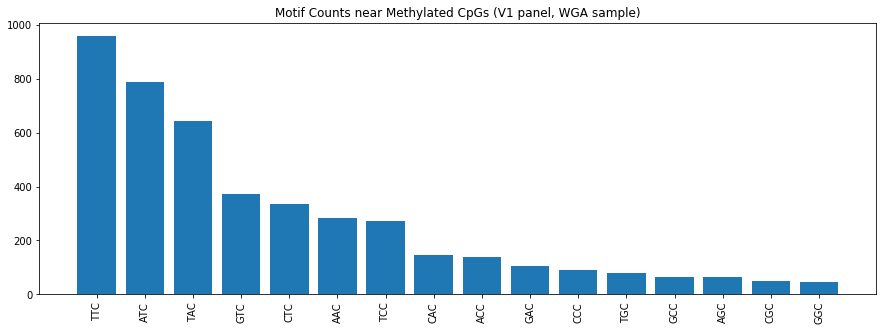

In [182]:
# plot results for v1 panel sample Methyl locations
result = all_counts_M
pickle_name=f"WGA_v1_sample_M_motif_counts_{pattern}"
motif_counts_M = summarize_chrm_counts(result, pickle_name=pickle_name)

FNAME = "Motif Counts near Methylated CpGs (V1 panel, WGA sample)"
plt.figure(figsize=(15,5))
plt.bar(x=range(len(motif_counts_M)), height=motif_counts_M.sort_values(ascending=False))#, tick_label=motif_totals.sort_values().index)
plt.xticks(range(len(motif_counts_M)), motif_counts_M.sort_values().index, rotation="vertical")
plt.title(FNAME)

In [ ]:
# FNAME = "Motif Counts near Methylated CpGs (V1 panel, 'NCN')"
# plt.figure(figsize=(15,5))
# plt.bar(x=range(len(motif_counts_M_ncn)), height=motif_counts_M.sort_values(ascending=False))#, tick_label=motif_totals.sort_values().index)
# plt.xticks(range(len(motif_counts_M_ncn)), motif_counts_M.sort_values().index, rotation="vertical")
# plt.title(FNAME)

## process control sites

In [183]:
# Get counts for test v1 panel file, NonMethyl sites, NCG motif

#bam = "/home/billiegould/src/Methyl/noise_motif_finder/test_zero_control_v1_panel.bam"
#regions_test = {"chr1":regions["chr1"][0:10], "chr2":regions["chr2"][0:10]}
#chrm_list = regions_test.keys()

#bam = "/home/billiegould/src/Methyl/noise_motif_finder/zero_control_v1_panel.bam"
bam = "/home/billiegould/src/Methyl/noise_motif_finder/WGA_zero_control_v1.bam"
chrm_list = regions_v1.keys()
regions_test = regions_v1
pattern="NNC"

all_counts_U = None
with Pool(cpu=23, memory='40GB') as pool:
    jobs = [pool.apply_async(chr_counts, 
                             bam=bam, 
                             chrm=chrm, 
                             regions_dict=regions_test, 
                             mode="control", 
                             ref=REF,
                             pattern=pattern) for chrm in chrm_list]
    all_counts_U = pool.gather(jobs)

<KubernetesCluster: uid=ccf6ba89-7b64-4f3c-b9b1-17b92ed7d04f namespace=default cpu=23 memory='40.00 GB' preemptible=True>

100%|██████████| 23/23 [01:39<00:00,  4.33s/it, Succeeded: 23, Failed: 0, Last: chr_counts-80c3501f5d1cd6383c5c3d9b79f00d47]


Num chrms: 23
(16, 561)
(16, 326)
(16, 343)
(16, 368)
(16, 250)
(16, 208)
(16, 216)
(16, 212)
(16, 282)
(16, 162)
(16, 242)
(16, 543)
(16, 166)
(16, 60)
(16, 62)
(16, 438)
(16, 400)
(16, 412)
(16, 424)
(16, 419)
(16, 399)
(16, 157)
(16, 20)
          0        1        2        3        4         5        6       7   \
CTC  15565.0  21168.0   8766.0  17733.0   5716.0   72500.0   4598.0   844.0   
AGC  15654.0  32305.0  10029.0  29345.0   6703.0   74763.0   5195.0  1212.0   
GCC  26027.0  59991.0  17626.0  43896.0  13233.0  123805.0   8700.0  1974.0   
GAC   9065.0  25363.0   4683.0  17713.0   4568.0   12773.0   2823.0   836.0   
GGC  30648.0  82047.0  19213.0  48610.0  13136.0  131437.0  10846.0  2517.0   

          8       9   ...      13     14       15       16       17       18  \
CTC   5416.0  3340.0  ...  1405.0  343.0  20379.0  24222.0  28158.0  11238.0   
AGC   5824.0  4434.0  ...  2217.0  356.0  25790.0  27242.0  22803.0  12695.0   
GCC   9774.0  7337.0  ...  3641.0  966.0  34

Text(0.5, 1.0, 'Motif Counts near UnMethylated CpGs (V1 panel, WGA sample)')

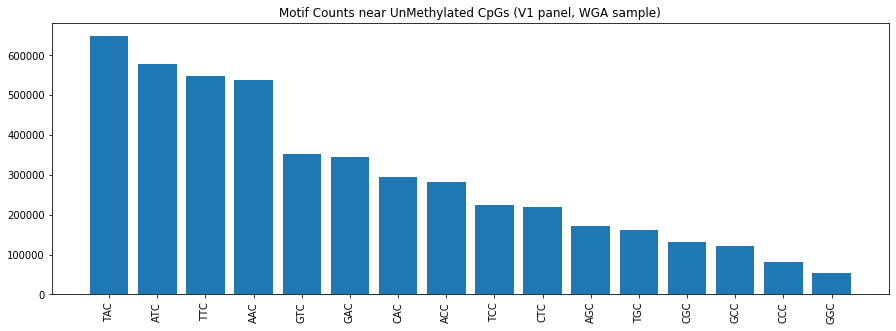

In [184]:
# summarize

result = all_counts_U
pickle_name = f"WGA_v1_sample_U_motif_counts_{pattern}"
 
motif_counts_U = summarize_chrm_counts(result, pickle_name=pickle_name)
#motif_counts_U

FNAME = "Motif Counts near UnMethylated CpGs (V1 panel, WGA sample)"
plt.figure(figsize=(15,5))
plt.bar(x=range(len(motif_counts_U)), height=motif_counts_U.sort_values(ascending=False))#, tick_label=motif_totals.sort_values().index)
plt.xticks(range(len(motif_counts_U)), motif_counts_U.sort_values().index, rotation="vertical")
plt.title(FNAME)

## plot enrichment

In [8]:
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

def enrich_test(s_methyl_counts, s_control_counts):
    #methyl_counts_dict = dict([i,ct for zip(methyl_counts.index, methyl_counts.values)])
    #control_counts_dict = dict([i,ct for zip(control_counts.index, control_counts.values)])
    
    p_vals = []
    diffs = []
    mpcts = []
    cpcts = []
    for motif in s_methyl_counts.index:
        mct = s_methyl_counts[motif]
        mtot = s_methyl_counts.values.sum()
        ctot = s_control_counts.values.sum()
        if motif in s_control_counts.index:
            cct = s_control_counts[motif]
        else:
            cct = 0
        
        #print(f"M: {round(mct/mtot,3)} U: {round(cct/ctot,3)}")
        ctable = np.array([[mct, cct],[mtot-mct, ctot-cct]])
        #print(ctable)
        chi2, p_val, dof, ex = chi2_contingency(ctable)
        
        mpcts.append(f"{(mct/float(mtot)):.3f}")
        cpcts.append(f"{(cct/float(ctot)):.3f}")
        diffs.append((mct/float(mtot) - cct/float(ctot)))
        p_vals.append(p_val)
        #print(f"pval: {p_val}")
    
    reject, q_vals = multipletests(p_vals, 0.05, method="bonferroni")[:2]
    q_vals_dict = dict([ (m,q) for m,q in zip(s_methyl_counts.index, q_vals)])
    #log_q_vals = [-np.log10(q) for q in q_vals]
    signif_bool = [q<=0.05 and diff>0 for q, diff in zip(q_vals, diffs)]
    signif_motifs = np.array(s_methyl_counts.index)[signif_bool]
    
    df_results = pd.DataFrame({"methylated":mpcts, "unmethylated":cpcts, "adj.pval":q_vals}).T
    df_results.columns = s_methyl_counts.index
    return df_results, q_vals_dict, signif_motifs

In [9]:
# optionally load teh pickle data (df_of chr counts by motif)
df_motif_counts_U = pickle.load(open("./WGA_v1_sample_U_motif_counts_NNC.pkl", "rb"))
df_motif_counts_M = pickle.load(open("./WGA_v1_sample_M_motif_counts_NNC.pkl", "rb"))
print(df_motif_counts_U.shape)
print(df_motif_counts_M.shape)

(16, 23)
(16, 23)


In [7]:
# barplot for comparison ### fix this to work on dataframe inputs and rerun

def plot_enrichment(df_motif_counts_M, df_motif_counts_U, title):
    #df_clust = pd.DataFrame(motif_counts_M.align(motif_counts_U)).T
    #df_p_vals_v1, v1_q_vals_dict, v1_signif_motifs = enrich_test(motif_counts_M, motif_counts_U)
    TITLE = f"Motif Counts, motif={pattern}"
    s_motif_sums_M = df_motif_counts_M.sum(axis=1)
    s_motif_sums_U = df_motif_counts_U.sum(axis=1)
    
    df_p_vals_v1, v1_q_vals_dict, v1_signif_motifs = enrich_test(s_motif_sums_M, s_motif_sums_U)

    df_clust = pd.concat([s_motif_sums_M, s_motif_sums_U], axis=1, join="outer")
    df_clust.columns = ["Methyl_CpG", "NonMethyl_CpG"]
    print(df_clust.head())
    df_clust_norm = df_clust / df_clust.sum(axis=0)
    df_clust_norm = df_clust_norm.sort_index()
    
    fig, ax = plt.subplots(figsize=(15,5))
    #plt.figure(figsize=(15,5))
    width=0.35
    x = np.arange(len(df_clust_norm))
    x2 = [a+width for a in x]
    U = ax.bar(x, df_clust_norm["NonMethyl_CpG"], width=width, label="NonMethylated")
    M = ax.bar(x2, df_clust_norm["Methyl_CpG"], width=width, label="Methylated")
    ind = np.arange(len(df_clust_norm))
    marks = ["*" if v1_q_vals_dict[m] <=0.05 else "" for m in df_clust_norm.index]
    for i in ind:
        ax.text(i, 1.05*(df_clust_norm.NonMethyl_CpG[i]), marks[i],
                    ha='center', va='bottom')

    ax.set_xticks(ind+width)
    ax.set_xticklabels(df_clust_norm.index, rotation="vertical")
    ax.set_ylabel("percent of motifs observed")
    plt.legend()
    plt.title(title)



In [157]:
df_M = pickle.load(open("./zero_v1_sample_M_motif_counts_NNNC.pkl","rb"))
df_U = pickle.load(open("./zero_v1_sample_U_motif_counts_NNNC.pkl","rb"))
title="Motif Enrichement pattern:NNNC, 0%met V1 panel sample"


In [172]:
df_M = pickle.load(open("./zero_S5_v3_sample_M_motif_counts_NNNC.pkl","rb"))
df_U = pickle.load(open("./zero_S5_v3_sample_U_motif_counts_NNNC.pkl","rb"))
title="Motif Enrichement pattern:NNNC, 0%met V3 panel sample"

In [16]:
df_M = pickle.load(open("./WGA_v1_sample_M_motif_counts_NNNC.pkl","rb"))
df_U = pickle.load(open("./WGA_v1_sample_U_motif_counts_NNNC.pkl","rb"))
title="Motif Enrichement pattern:NNNC, 0%met WGA V1 panel sample"
pattern="NNNC"

In [176]:
df_M = pickle.load(open("./zero_v1_sample_M_motif_counts_NNC.pkl","rb"))
df_U = pickle.load(open("./zero_v1_sample_U_motif_counts_NNC.pkl","rb"))
title="Motif Enrichement pattern:NNC, 0%met V1 panel sample"

In [178]:
df_M = pickle.load(open("./zero_S5_v3_sample_M_motif_counts_NNC.pkl","rb"))
df_U = pickle.load(open("./zero_S5_v3_sample_U_motif_counts_NNC.pkl","rb"))
title="Motif Enrichement pattern:NNC, 0%met V3 panel sample"

In [12]:
df_M = pickle.load(open("./WGA_v1_sample_M_motif_counts_NNC.pkl","rb"))
df_U = pickle.load(open("./WGA_v1_sample_U_motif_counts_NNC.pkl","rb"))
title="Motif Enrichement pattern:NNC, 0%met WGA V1 panel sample"
pattern="NNC"

In [187]:
df_M = pickle.load(open("./zero_v1_sample_M_motif_counts_NCGN.pkl","rb"))
df_U = pickle.load(open("./zero_v1_sample_U_motif_counts_NCGN.pkl","rb"))
title="Motif Enrichement pattern:NCGN, 0%met V1 panel sample"

      Methyl_CpG  NonMethyl_CpG
GAGC       399.0       130008.0
ATTC         5.0        20240.0
GCGC       456.0       234799.0
GGGC       381.0       212268.0
GTGC       144.0        98336.0


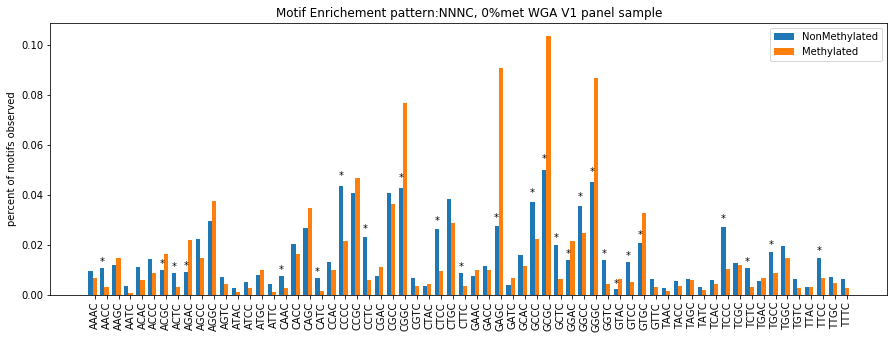

In [17]:
plot_enrichment(df_M, df_U, title=title)

In [14]:
# d_WGA_m = pickle.load(open("./WGA_v1_sample_M_motif_counts_NNC.pkl", "rb"))
# d_V1_m = pickle.load(open("./zero_v1_sample_M_motif_counts_NNC.pkl", "rb"))
# d_V3_m = pickle.load(open("./zero_S5_v3_sample_M_motif_counts_NNC.pkl", "rb"))
# d_WGA_u = pickle.load(open("./WGA_v1_sample_U_motif_counts_NNC.pkl", "rb"))
# d_V1_u = pickle.load(open("./zero_v1_sample_U_motif_counts_NNC.pkl", "rb"))
# d_V3_u = pickle.load(open("./zero_S5_v3_sample_U_motif_counts_NNC.pkl", "rb"))

d_WGA_m = pickle.load(open("./WGA_v1_sample_M_motif_counts_NNC.pkl", "rb"))
d_V1_m = pickle.load(open("./zero_v1_sample_M_motif_counts_NNC.pkl", "rb"))
d_V3_m = pickle.load(open("./zero_S5_v3_sample_M_motif_counts_NNC.pkl", "rb"))
d_WGA_u = pickle.load(open("./WGA_v1_sample_U_motif_counts_NNC.pkl", "rb"))
d_V1_u = pickle.load(open("./zero_v1_sample_U_motif_counts_NNC.pkl", "rb"))
d_V3_u = pickle.load(open("./zero_S5_v3_sample_U_motif_counts_NNC.pkl", "rb"))


def diff(df_m, df_u):
    s_m = df_m.sum(axis=1)
    s_u = df_u.sum(axis=1)
    df = pd.concat([s_m,s_u], axis=1, join="outer")
    print(df.head())
    df_norm = df / df.sum(axis=0)
    df_norm.columns = ["M","U"]
    #print(df_norm.head())
    return df_norm.M - df_norm.U

diffs = [diff(d_WGA_m, d_WGA_u), diff(d_V1_m, d_V1_u), diff(d_V3_m, d_V3_u)]
#df_clust = pd.DataFrame(sr_WGA.align(sr_V1))
#df_clust = pd.DataFrame(df_clust.align(sr_V3, axis=0)).T
df_clust = pd.DataFrame(pd.concat(diffs, axis=1, join="outer"))
df_clust.columns = ["V1_WGA", "V1", "V3"]
print(df_clust.head())
print(df_clust.shape)



         0         1
AGC  645.0  344128.0
TTC   46.0  121283.0
CGC  789.0  536164.0
GGC  960.0  648697.0
TGC  336.0  352318.0
            0           1
GGC  268580.0  11063016.0
CGC  237516.0   9018380.0
CAC   73919.0   2640330.0
CCC  147782.0   9699233.0
TGC  169165.0   4254473.0
            0           1
GGC  438460.0  26457471.0
GAC  116280.0   6839603.0
TCC  176711.0  10645654.0
CGC  409070.0  22180219.0
GCC  312532.0  24120034.0
       V1_WGA        V1        V3
AGC  0.072765  0.024451  0.030295
TTC -0.015193  0.005846  0.004171
CGC  0.064738  0.001398  0.026216
GGC  0.079541 -0.010607  0.013351
TGC  0.001445  0.031546  0.023374
(16, 3)


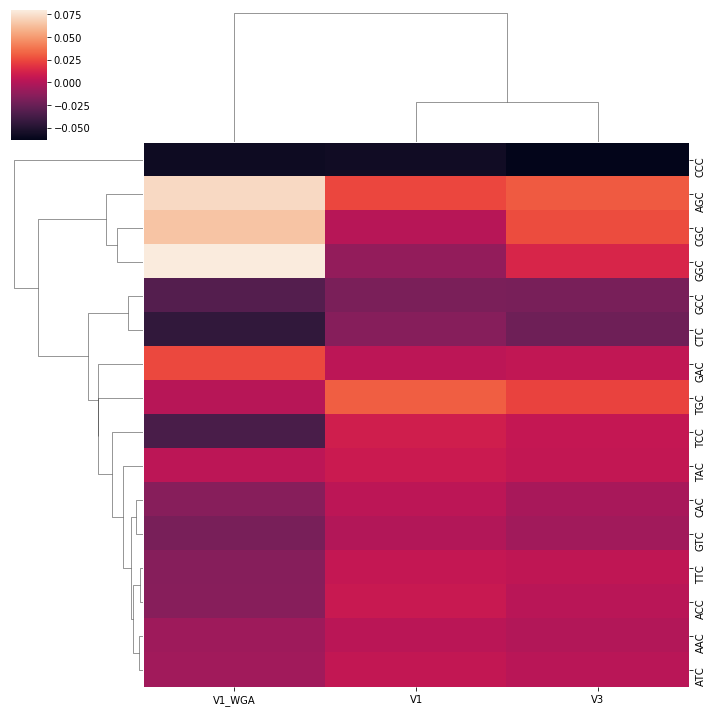

In [15]:
clustermap(df_clust,
          xticklabels=True,
          yticklabels=True)

## test V3 panel samples

In [ ]:
# JIRA https://freenome.atlassian.net/browse/RRFS-47

In [ ]:
# samples : gs://seq-data-us-1/bam/200401_A00225_0380_BHWHGGDSXX/24db8989-0af4-5f9e-89dc-a60d179faa59
# 5,HCT116_0met,E1,5,5,574,idt-20170126,tem_seq,1061,methyl_panel_v3
# 12,HCT116_0met,D2,12,12,574,idt-20170126,tem_seq,1068,methyl_panel_v3



!gsutil cp gs://seq-data-us-1/bam/200401_A00225_0380_BHWHGGDSXX/f80335f6-9266-5cbc-834e-4d7b2a7265c4/S_05_I_05-05_TGTTCCGT-TGTTCCGT_S5.marked.bam ./S5_0met_V3_panel.bam

In [93]:
!gsutil cp gs://seq-data-us-1/bam/200401_A00225_0380_BHWHGGDSXX/f80335f6-9266-5cbc-834e-4d7b2a7265c4/S_12_I_12-12_CCTAAGTC-CCTAAGTC_S12.marked.bam ./S12_0met_V3_panel.bam

Copying gs://seq-data-us-1/bam/200401_A00225_0380_BHWHGGDSXX/f80335f6-9266-5cbc-834e-4d7b2a7265c4/S_12_I_12-12_CCTAAGTC-CCTAAGTC_S12.marked.bam...
/ [1 files][ 12.3 GiB/ 12.3 GiB]   16.0 MiB/s                                   
Operation completed over 1 objects/12.3 GiB.                                     


In [115]:
num_reads_in_file = 245898212 # mapped and prop paired
num_reads_dups = 209356558 #85%
num_non_dups = num_reads_in_file - num_reads_dups
print(num_non_dups)
reads_per_region = num_non_dups/3197
reads_per_region

36541654


11429.982483578355

In [114]:
#read in V3
regions_v3 = defaultdict(list)
names = []
with open("../methyl_panel_v3_target_twist.bed", "r") as fin:
    for line in fin:
        chrom, start, stop = line.split("\t")
        name = f"{chrom}:{start}"
        regions_v3[chrom].append((int(start), int(stop), name))
        assert name not in names
        names.append(name) # none of the region names are duplicated
    
print(len(regions_v3)) 
print(regions_v3["chr1"][0:3])  #3197 regions

22
[(998470, 1001094, 'chr1:998470'), (1324213, 1325305, 'chr1:1324213'), (1406678, 1407605, 'chr1:1406678')]


### process methylated sites

In [123]:
# get counts near methyl cpgs, v3 sample
bam = "/home/billiegould/src/Methyl/noise_motif_finder/S5_0met_V3_panel.bam"
chrm_list = regions_v3.keys()
regions_test = regions_v3
pattern = "NNNC"

all_counts_M = None
with Pool(cpu=22, memory='40GB') as pool:
    jobs = [pool.apply_async(chr_counts, 
                             bam=bam, 
                             chrm=chrm, 
                             regions_dict=regions_test, 
                             mode="test", 
                             ref=REF,
                             pattern=pattern) for chrm in chrm_list]
    all_counts_M = pool.gather(jobs)

<KubernetesCluster: uid=12734efe-10fd-4d74-be2f-6048ebb42ee5 namespace=default cpu=22 memory='40.00 GB' preemptible=True>

100%|██████████| 22/22 [09:15<00:00, 25.26s/it, Succeeded: 22, Failed: 0, Last: chr_counts-58780d63adf86606347d9194aadd79ad] 


Num chrms: 22
(64, 263)
(64, 166)
(64, 182)
(64, 143)
(64, 89)
(64, 101)
(64, 114)
(64, 129)
(64, 194)
(64, 84)
(64, 153)
(64, 246)
(64, 109)
(64, 36)
(64, 68)
(64, 181)
(64, 144)
(64, 173)
(64, 177)
(64, 179)
(64, 147)
(64, 115)
           0        1       2       3        4       5       6       7   \
GGGC  11968.0   9694.0  6247.0  6188.0   6734.0  3835.0  6102.0  4911.0   
GGAC   3440.0   2567.0  1650.0  2029.0   1976.0  1165.0  1029.0  1086.0   
GTCC   2108.0   2069.0   934.0  1378.0   1705.0   576.0  1312.0   465.0   
GCGC  14962.0  10650.0  5956.0  9330.0  12322.0  4872.0  5996.0  4100.0   
CCCC   6042.0   4543.0  2036.0  4615.0   4594.0  1466.0  2376.0  1408.0   

           8        9   ...      12      13      14       15      16       17  \
GGGC  11810.0   6079.0  ...  3549.0  2729.0  2595.0   9739.0  6043.0   8077.0   
GGAC   3062.0   2062.0  ...  1071.0  1326.0   491.0   2572.0  1747.0   3985.0   
GTCC   2007.0   1568.0  ...   640.0   693.0   196.0   2015.0  1309.0   2280.

Text(0.5, 1.0, 'Motif Counts near Methylated CpGs (V3 panel, S5 sample)')

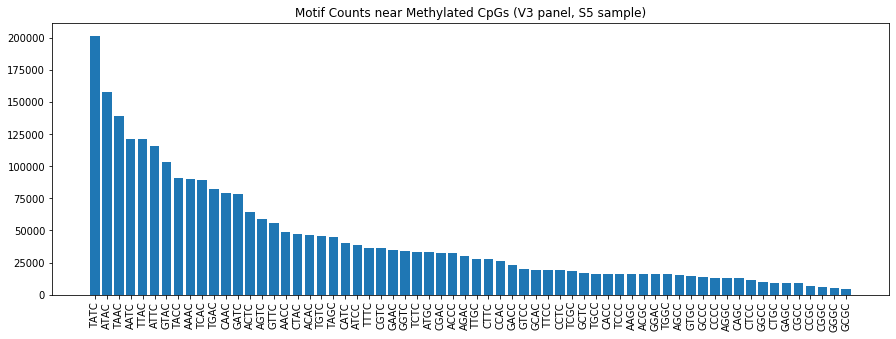

In [124]:
# plot results for v1 panel sample Methyl locations
result = all_counts_M
pickle_name=f"zero_S5_v3_sample_M_motif_counts_{pattern}"
motif_counts_M = summarize_chrm_counts(result, pickle_name=pickle_name)

FNAME = "Motif Counts near Methylated CpGs (V3 panel, S5 sample)"
plt.figure(figsize=(15,5))
plt.bar(x=range(len(motif_counts_M)), height=motif_counts_M.sort_values(ascending=False))#, tick_label=motif_totals.sort_values().index)
plt.xticks(range(len(motif_counts_M)), motif_counts_M.sort_values().index, rotation="vertical")
plt.title(FNAME)

### process unmethylated sites

In [125]:
bam = "/home/billiegould/src/Methyl/noise_motif_finder/S5_0met_V3_panel.bam"
chrm_list = regions_v3.keys()
regions_test = regions_v3
pattern = "NNNC"

all_counts_U = None
with Pool(cpu=23, memory='40GB') as pool:
    jobs = [pool.apply_async(chr_counts, 
                             bam=bam, 
                             chrm=chrm, 
                             regions_dict=regions_test, 
                             mode="control", 
                             ref=REF,
                             pattern=pattern) for chrm in chrm_list]
    all_counts_U = pool.gather(jobs)

<KubernetesCluster: uid=9b227992-6a91-4cb5-bd46-fa590959450d namespace=default cpu=23 memory='40.00 GB' preemptible=True>

100%|██████████| 22/22 [11:24<00:00, 31.10s/it, Succeeded: 22, Failed: 0, Last: chr_counts-e9da1c4ff4dff8823e2f3993590bf31e] 


Num chrms: 22
(64, 263)
(64, 166)
(64, 182)
(64, 143)
(64, 89)
(64, 101)
(64, 114)
(64, 129)
(64, 194)
(64, 84)
(64, 153)
(64, 246)
(64, 109)
(64, 36)
(64, 68)
(64, 181)
(64, 144)
(64, 173)
(64, 177)
(64, 179)
(64, 147)
(64, 115)
            0         1         2         3         4         5         6   \
ACTC  102879.0   97916.0   79504.0   65350.0   41259.0   48420.0   47082.0   
GTGC  214406.0  198592.0  157437.0  131941.0   74693.0   99346.0   98420.0   
CCTC  312887.0  290843.0  226140.0  180102.0  113266.0  140827.0  159132.0   
CTGC  364340.0  348620.0  291554.0  217774.0  141502.0  167979.0  186261.0   
CGCC  625856.0  543263.0  437410.0  358515.0  246713.0  272828.0  330124.0   

            7         8         9   ...        12       13        14  \
ACTC   50121.0  115345.0   40475.0  ...   51972.0  15326.0   24645.0   
GTGC  131746.0  237917.0   83791.0  ...  115098.0  35018.0   62034.0   
CCTC  187547.0  360678.0  115984.0  ...  151869.0  50326.0   80086.0   
CTGC  221685.

Text(0.5, 1.0, 'Motif Counts near UnMethylated CpGs (V3 panel, sample S5)')

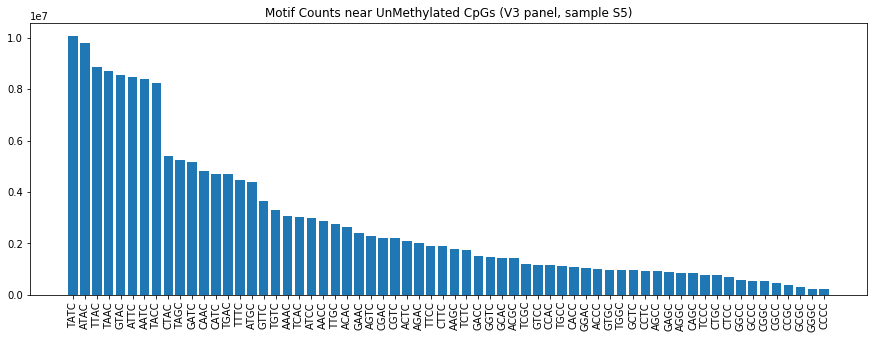

In [126]:
# summarize
result = all_counts_U
pickle_name = f"zero_S5_v3_sample_U_motif_counts_{pattern}"
 
motif_counts_U = summarize_chrm_counts(result, pickle_name=pickle_name)
#motif_counts_U

FNAME = "Motif Counts near UnMethylated CpGs (V3 panel, sample S5)"
plt.figure(figsize=(15,5))
plt.bar(x=range(len(motif_counts_U)), height=motif_counts_U.sort_values(ascending=False))#, tick_label=motif_totals.sort_values().index)
plt.xticks(range(len(motif_counts_U)), motif_counts_U.sort_values().index, rotation="vertical")
plt.title(FNAME)

### test V3 panel motif enrichment

In [ ]:
# load data
motif_counts_M = pickle.load()
motif_counts_U = pickle.load()
pattern = ""

M: 0.057 U: 0.054
pval: 2.2663475493498606e-126
M: 0.018 U: 0.016
pval: 2.701745544801549e-67
M: 0.012 U: 0.013
pval: 5.427749657498431e-49
M: 0.073 U: 0.049
pval: 0.0
M: 0.029 U: 0.056
pval: 0.0
M: 0.028 U: 0.046
pval: 0.0
M: 0.03 U: 0.026
pval: 0.0
M: 0.01 U: 0.008
pval: 1.1179816318083804e-217
M: 0.013 U: 0.013
pval: 1.8171313407942497e-21
M: 0.007 U: 0.011
pval: 0.0
M: 0.023 U: 0.017
pval: 0.0
M: 0.044 U: 0.048
pval: 4.343628574289536e-195
M: 0.012 U: 0.011
pval: 1.4367096344309695e-65
M: 0.01 U: 0.017
pval: 0.0
M: 0.008 U: 0.005
pval: 0.0
M: 0.005 U: 0.005
pval: 3.3710507702171266e-05
M: 0.02 U: 0.018
pval: 2.1950263298681446e-149
M: 0.038 U: 0.029
pval: 0.0
M: 0.01 U: 0.008
pval: 1.3183878649617435e-203
M: 0.042 U: 0.026
pval: 0.0
M: 0.033 U: 0.03
pval: 6.801087041231517e-196
M: 0.017 U: 0.028
pval: 0.0
M: 0.033 U: 0.045
pval: 0.0
M: 0.044 U: 0.047
pval: 8.796610668671031e-138
M: 0.033 U: 0.027
pval: 0.0
M: 0.051 U: 0.047
pval: 6.590488927390042e-199
M: 0.012 U: 0.015
pval: 0.0
M

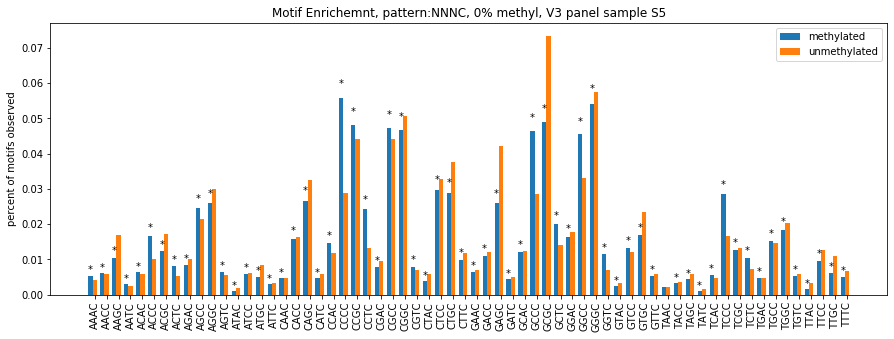

In [127]:
TITLE = f"Motif Enrichemnt, pattern:{pattern}, 0% methyl, V3 panel sample S5"
plot_enrichment(motif_counts_M, motif_counts_U, title=TITLE)